In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pathlib import Path
from sqlalchemy import create_engine
from ds100_utils import fetch_and_cache

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)

## SQL Joins

In [2]:
import sqlite3
conn = sqlite3.connect('test.db')

In [3]:
conn.executescript("""
DROP TABLE IF EXISTS s;
DROP TABLE IF EXISTS t;

CREATE TABLE s(
    id INTEGER PRIMARY KEY, 
    name TEXT
);

INSERT INTO s VALUES 
    (0, 'Apricot'),
    (1, 'Boots'),
    (2, 'Cally'),
    (4, 'Eugene');

CREATE TABLE t(
    id INTEGER PRIMARY KEY,
    breed TEXT
);

INSERT INTO t VALUES 
    (1, 'persian'),
    (2, 'ragdoll'),
    (4, 'bengal'),
    (5, 'persian');
""");

In [4]:
def print_sql(s):
    first, *rest = s.strip().split('\n')
    print(f'sql> {first}')
    for line in rest:
        print(f'...> {line}')
    for result in conn.execute(s):
        print(result)

print_sql('SELECT * FROM s;')
print_sql('SELECT * FROM t;')

sql> SELECT * FROM s;
(0, 'Apricot')
(1, 'Boots')
(2, 'Cally')
(4, 'Eugene')
sql> SELECT * FROM t;
(1, 'persian')
(2, 'ragdoll')
(4, 'bengal')
(5, 'persian')


In [5]:
query = '''
SELECT *
FROM s
WHERE id >= 2;
'''

print_sql(query)

sql> SELECT *
...> FROM s
...> WHERE id >= 2;
(2, 'Cally')
(4, 'Eugene')


In [6]:
#cross join
query = '''
SELECT *
FROM s, t
'''
print_sql(query)

sql> SELECT *
...> FROM s, t
(0, 'Apricot', 1, 'persian')
(0, 'Apricot', 2, 'ragdoll')
(0, 'Apricot', 4, 'bengal')
(0, 'Apricot', 5, 'persian')
(1, 'Boots', 1, 'persian')
(1, 'Boots', 2, 'ragdoll')
(1, 'Boots', 4, 'bengal')
(1, 'Boots', 5, 'persian')
(2, 'Cally', 1, 'persian')
(2, 'Cally', 2, 'ragdoll')
(2, 'Cally', 4, 'bengal')
(2, 'Cally', 5, 'persian')
(4, 'Eugene', 1, 'persian')
(4, 'Eugene', 2, 'ragdoll')
(4, 'Eugene', 4, 'bengal')
(4, 'Eugene', 5, 'persian')


In [7]:
#inner join
query = '''
SELECT *
FROM s JOIN t
  ON s.id = t.id
'''
print_sql(query)

sql> SELECT *
...> FROM s JOIN t
...>   ON s.id = t.id
(1, 'Boots', 1, 'persian')
(2, 'Cally', 2, 'ragdoll')
(4, 'Eugene', 4, 'bengal')


In [8]:
#left inner join
query = '''
SELECT *
FROM s LEFT JOIN t
  ON s.id = t.id
'''
print_sql(query)

sql> SELECT *
...> FROM s LEFT JOIN t
...>   ON s.id = t.id
(0, 'Apricot', None, None)
(1, 'Boots', 1, 'persian')
(2, 'Cally', 2, 'ragdoll')
(4, 'Eugene', 4, 'bengal')


In [9]:
#right inner join unsupported, so we have to switch s and t
query = '''
SELECT *
FROM t LEFT JOIN s
  ON s.id = t.id
'''
print_sql(query)

sql> SELECT *
...> FROM t LEFT JOIN s
...>   ON s.id = t.id
(1, 'persian', 1, 'Boots')
(2, 'ragdoll', 2, 'Cally')
(4, 'bengal', 4, 'Eugene')
(5, 'persian', None, None)


Doing an outer join is possible but is not very concise and requires UNION keyword. Not shown here.

## Legislator Example

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)

In lecture 12, we wanted to create a table where every row contained the age of a congressperson on January 25th of a given year. Our ultimate goal was to produce the plot below:

![legislator_figure.png](legislator_figure.png)

First we created a table with each legislator's terms.

In [11]:
legs_with_terms = pd.read_csv("legs_with_terms.csv")
legs_with_terms = legs_with_terms.drop(["state", "party", "gender"], axis = 1)
legs_with_terms["start"] = pd.to_datetime(legs_with_terms["start"])
legs_with_terms["end"] = pd.to_datetime(legs_with_terms["end"])
legs_with_terms["birthday"] = pd.to_datetime(legs_with_terms["birthday"])
legs_with_terms.query("first == 'Cory'")
#legs_with_terms.iloc[[24003, 24004, 24005, -2, -1], :]

,leg_id,term,type,start,end,first,last,terms,birthday
41917,G000562,1,House,2011-01-05,2013-01-03,Cory,Gardner,3,1974-08-22
41918,G000562,2,House,2013-01-03,2015-01-03,Cory,Gardner,3,1974-08-22
41919,G000562,3,Senate,2015-01-06,2021-01-03,Cory,Gardner,3,1974-08-22
43620,B001288,1,Senate,2013-10-31,2015-01-03,Cory,Booker,2,1969-04-27
43621,B001288,2,Senate,2015-01-06,2021-01-03,Cory,Booker,2,1969-04-27


Above, each row gives the date that each congressperson began each of their terms. This is not quite what we want.

Instead, we want to know the date that each congressperson was on January 25th of the given year. For example, above, we'd want to compute that Cory Gardner was 36, 38, 40, 42, and 44 in the years 2011, 2013, 2015, 2017, 2019 and that Cory Booker was 45, 47, and 49 in the years 2015, 2017, and 2019.

To do this, we created a series of dates corresponding to January 25th of each year, starting in 1941 (we ignored sessions of congress before 1941).

In [12]:
target_dates = pd.to_datetime([f'01-25-{n}' for n in range(1941, 2020, 2)])
#the line below is just a fancy way of making the target_dates object look nice
target_dates.to_frame().reset_index().drop("index", axis = 1).rename(columns = {0: "target_dates"})

,target_dates
0,1941-01-25
1,1943-01-25
...,...
38,2017-01-25
39,2019-01-25


With some clever joining we can combine these two tables. First we create a SQL database and put our two tables from above into this database.

In [14]:
import sqlite3
conn = sqlite3.connect(':memory:')
legs_with_terms.to_sql("legs_with_terms", conn)
pd.DataFrame({'target_date': target_dates}).to_sql('target_dates', conn)
for exp in conn.execute('SELECT sql FROM sqlite_master'):
    print(exp[0])

CREATE TABLE "legs_with_terms" (
"index" INTEGER,
  "leg_id" TEXT,
  "term" INTEGER,
  "type" TEXT,
  "start" TIMESTAMP,
  "end" TIMESTAMP,
  "first" TEXT,
  "last" TEXT,
  "terms" INTEGER,
  "birthday" TIMESTAMP
)
CREATE INDEX "ix_legs_with_terms_index"ON "legs_with_terms" ("index")
CREATE TABLE "target_dates" (
"index" INTEGER,
  "target_date" TIMESTAMP
)
CREATE INDEX "ix_target_dates_index"ON "target_dates" ("index")


All it takes is a clever join condition. 

In [15]:
query = """
    SELECT target_date, type, first, last, 
           birthday, target_date - birthday AS age
    FROM legs_with_terms, target_dates 
    WHERE start <= target_date AND target_date < end
    """

df_sql = pd.read_sql(query, conn)
df_sql.query("first == 'Cory'")

,target_date,type,first,last,birthday,age
19573,2011-01-25 00:00:00,House,Cory,Gardner,1974-08-22 00:00:00,37.0
19574,2013-01-25 00:00:00,House,Cory,Gardner,1974-08-22 00:00:00,39.0
...,...,...,...,...,...,...
21384,2017-01-25 00:00:00,Senate,Cory,Booker,1969-04-27 00:00:00,48.0
21385,2019-01-25 00:00:00,Senate,Cory,Booker,1969-04-27 00:00:00,50.0


#### Pandas Version

In pandas, we have to somehow combine our two tables (legs_with_terms and target_dates). Doing this efficiently in pandas is hard and requires some fairly tricky syntax that I basically just copied from stack overflow and don't fully understand. The code I used in lecture 12 is below

In [38]:
# a bit of hack inspired by https://stackoverflow.com/questions/44367672/best-way-to-join-merge-by-range-in-pandas

dates_of_interest = target_dates.values
term_endings = legs_with_terms["end"].values
term_beginnings = legs_with_terms["start"].values

i, j = np.where((dates_of_interest[:, None] >= term_beginnings) 
                & (dates_of_interest[:, None] <= term_endings))

df_pandas = pd.DataFrame(
    np.column_stack([target_dates.values[i], legs_with_terms.values[j]]),
    columns=pd.Index(["target_date"]).append(legs_with_terms.columns)
)
df_pandas = df_pandas.astype({"target_date": "datetime64[ns]"})

df_pandas["age"] = np.round((df_pandas["target_date"] - df_pandas["birthday"]).dt.days / 365.0, 2)

In [39]:
df_pandas.query("first == 'Cory'") 

,target_date,leg_id,term,type,start,end,first,last,terms,birthday,age
19442,2011-01-25,G000562,1,House,2011-01-05,2013-01-03,Cory,Gardner,3,1974-08-22,36.45
19912,2013-01-25,G000562,2,House,2013-01-03,2015-01-03,Cory,Gardner,3,1974-08-22,38.45
...,...,...,...,...,...,...,...,...,...,...,...
21318,2019-01-25,G000562,3,Senate,2015-01-06,2021-01-03,Cory,Gardner,3,1974-08-22,44.46
21545,2019-01-25,B001288,2,Senate,2015-01-06,2021-01-03,Cory,Booker,2,1969-04-27,49.78


## IMDB Data

In [40]:
data_directory = './'

In [41]:
# From https://www.imdb.com/interfaces/
fetch_and_cache('https://datasets.imdbws.com/title.basics.tsv.gz', 'titles.tsv.gz', data_directory)
fetch_and_cache('https://datasets.imdbws.com/name.basics.tsv.gz', 'names.tsv.gz', data_directory)
!gunzip -kf {data_directory}/titles.tsv.gz
!gunzip -kf {data_directory}/names.tsv.gz
!ls -lh {data_directory}

Using cached version that was downloaded (UTC): Tue Nov 19 06:02:39 2019
Using cached version that was downloaded (UTC): Tue Nov 19 06:02:44 2019
total 2.5G
-rwxrwxrwx 1 hug hug 1.2G Nov 19 09:11 imdb.db
-rwxrwxrwx 1 hug hug 554M Nov 19 06:02 names.tsv
-rwxrwxrwx 1 hug hug 181M Nov 19 06:02 names.tsv.gz
-rwxrwxrwx 1 hug hug 513M Nov 19 06:02 titles.tsv
-rwxrwxrwx 1 hug hug 108M Nov 19 06:02 titles.tsv.gz


In [42]:
# Running the line below will probaly crash your kernel because the names 
# dataset is too big to comfortable fit into main memory. 
#pd.read_csv(f'{data_directory}/names.tsv', sep='\t')

In [43]:
# Using sqlite3 instead allows us to (must be run from the terminal)
# note: To close sqlite3, press ctrl-d
"""
$ sqlite3 imdb.db
sqlite> .mode tabs
sqlite> .import titles.tsv titles
sqlite> .import names.tsv names
""";

While the code above runs, let's explore the data files a bit.

In [44]:
!wc {data_directory}/*.tsv

   9708708   66861040  579862674 /home/hug/X/temp/lec24/names.tsv
   6323825   85897998  537278118 /home/hug/X/temp/lec24/titles.tsv
  16032533  152759038 1117140792 total


In [45]:
!head -n5 {data_directory}/titles.tsv

tconst	titleType	primaryTitle	originalTitle	isAdult	startYear	endYear	runtimeMinutes	genres
tt0000001	short	Carmencita	Carmencita	0	1894	\N	1	Documentary,Short
tt0000002	short	Le clown et ses chiens	Le clown et ses chiens	0	1892	\N	5	Animation,Short
tt0000003	short	Pauvre Pierrot	Pauvre Pierrot	0	1892	\N	4	Animation,Comedy,Romance
tt0000004	short	Un bon bock	Un bon bock	0	1892	\N	\N	Animation,Short


In [46]:
!head -n5 {data_directory}/names.tsv

nconst	primaryName	birthYear	deathYear	primaryProfession	knownForTitles
nm0000001	Fred Astaire	1899	1987	soundtrack,actor,miscellaneous	tt0050419,tt0043044,tt0053137,tt0072308
nm0000002	Lauren Bacall	1924	2014	actress,soundtrack	tt0117057,tt0038355,tt0071877,tt0037382
nm0000003	Brigitte Bardot	1934	\N	actress,soundtrack,producer	tt0057345,tt0054452,tt0049189,tt0059956
nm0000004	John Belushi	1949	1982	actor,writer,soundtrack	tt0078723,tt0080455,tt0077975,tt0072562


In [47]:
conn = sqlite3.connect(data_directory + '/imdb.db')
print_sql('SELECT * FROM titles LIMIT 10;')

sql> SELECT * FROM titles LIMIT 10;
('tt0000001', 'short', 'Carmencita', 'Carmencita', '0', '1894', '\\N', '1', 'Documentary,Short')
('tt0000002', 'short', 'Le clown et ses chiens', 'Le clown et ses chiens', '0', '1892', '\\N', '5', 'Animation,Short')
('tt0000003', 'short', 'Pauvre Pierrot', 'Pauvre Pierrot', '0', '1892', '\\N', '4', 'Animation,Comedy,Romance')
('tt0000004', 'short', 'Un bon bock', 'Un bon bock', '0', '1892', '\\N', '\\N', 'Animation,Short')
('tt0000005', 'short', 'Blacksmith Scene', 'Blacksmith Scene', '0', '1893', '\\N', '1', 'Comedy,Short')
('tt0000006', 'short', 'Chinese Opium Den', 'Chinese Opium Den', '0', '1894', '\\N', '1', 'Short')
('tt0000007', 'short', 'Corbett and Courtney Before the Kinetograph', 'Corbett and Courtney Before the Kinetograph', '0', '1894', '\\N', '1', 'Short,Sport')
('tt0000008', 'short', 'Edison Kinetoscopic Record of a Sneeze', 'Edison Kinetoscopic Record of a Sneeze', '0', '1894', '\\N', '1', 'Documentary,Short')
('tt0000009', 'movie', '

In [48]:
for exp in conn.execute('SELECT sql FROM sqlite_master;'):
    print(exp[0])

CREATE TABLE titles(
  "tconst" TEXT,
  "titleType" TEXT,
  "primaryTitle" TEXT,
  "originalTitle" TEXT,
  "isAdult" TEXT,
  "startYear" TEXT,
  "endYear" TEXT,
  "runtimeMinutes" TEXT,
  "genres" TEXT
)
CREATE TABLE names(
  "nconst" TEXT,
  "primaryName" TEXT,
  "birthYear" TEXT,
  "deathYear" TEXT,
  "primaryProfession" TEXT,
  "knownForTitles" TEXT
)
CREATE TABLE "action"(
  id TEXT,
  title TEXT,
  time INT,
  year INT
)
CREATE TABLE action_movie(
  id TEXT,
  title TEXT,
  time INT,
  year INT
)
CREATE TABLE action_ppl(
  name TEXT,
  profession,
  born INT,
  title TEXT,
  year INT
)


In [49]:
# Reminder: Python f strings
who, where = 'John', 'here'
f"{who} is {where}"

'John is here'

In [50]:
get_10_movies = f'''
SELECT primaryTitle AS title, 
  runtimeMinutes AS time
FROM titles
LIMIT 10;
'''

print_sql(get_10_movies)

sql> SELECT primaryTitle AS title, 
...>   runtimeMinutes AS time
...> FROM titles
...> LIMIT 10;
('Carmencita', '1')
('Le clown et ses chiens', '5')
('Pauvre Pierrot', '4')
('Un bon bock', '\\N')
('Blacksmith Scene', '1')
('Chinese Opium Den', '1')
('Corbett and Courtney Before the Kinetograph', '1')
('Edison Kinetoscopic Record of a Sneeze', '1')
('Miss Jerry', '45')
('Exiting the Factory', '1')


In [51]:
get_10_movies_time_as_int = f'''
SELECT primaryTitle AS title, 
  CAST(runtimeMinutes as int) AS time
FROM titles
LIMIT 10;
'''

print_sql(get_10_movies_time_as_int)

sql> SELECT primaryTitle AS title, 
...>   CAST(runtimeMinutes as int) AS time
...> FROM titles
...> LIMIT 10;
('Carmencita', 1)
('Le clown et ses chiens', 5)
('Pauvre Pierrot', 4)
('Un bon bock', 0)
('Blacksmith Scene', 1)
('Chinese Opium Den', 1)
('Corbett and Courtney Before the Kinetograph', 1)
('Edison Kinetoscopic Record of a Sneeze', 1)
('Miss Jerry', 45)
('Exiting the Factory', 1)


In [52]:
select_action = f'''
SELECT tconst AS id,
  primaryTitle AS title, 
  CAST(runtimeMinutes AS int) AS time, 
  CAST(startYear AS int) AS year
FROM titles
WHERE genres LIKE '%Action%' AND
  year > 1900 AND 
  isAdult = '0' AND
  titleType = 'movie' AND
  time > 60 AND time < 180
'''

create_action_table = f'''
DROP TABLE IF EXISTS action_movie;
CREATE TABLE action_movie AS {select_action};
'''

conn.executescript(create_action_table)
print_sql('SELECT * FROM action_movie LIMIT 10')

sql> SELECT * FROM action_movie LIMIT 10
('tt0004223', 'The Life of General Villa', 105, 1914)
('tt0004450', 'Die Pagode', 82, 1917)
('tt0004635', 'The Squaw Man', 74, 1914)
('tt0005073', 'The Chalice of Courage', 65, 1915)
('tt0006333', '20,000 Leagues Under the Sea', 105, 1916)
('tt0006997', 'The Warrior', 95, 1916)
('tt0007168', 'Die Peitsche', 85, 1916)
('tt0008114', 'Die Hochzeit im Excentricclub', 70, 1917)
('tt0008915', 'Bound in Morocco', 64, 1918)
('tt0009560', 'The Romance of Tarzan', 70, 1918)


We can check to see whether this table is small enough to read into pandas:

In [53]:
print_sql('SELECT COUNT(*) from action_movie')

sql> SELECT COUNT(*) from action_movie
(20139,)


In [54]:
df = pd.read_sql('SELECT * FROM action_movie', conn)
df

,id,title,time,year
0,tt0004223,The Life of General Villa,105,1914
1,tt0004450,Die Pagode,82,1917
...,...,...,...,...
20137,tt9904066,Fox Hunting,66,2019
20138,tt9916190,Safeguard,90,2020


In [55]:
df.shape

(20139, 4)

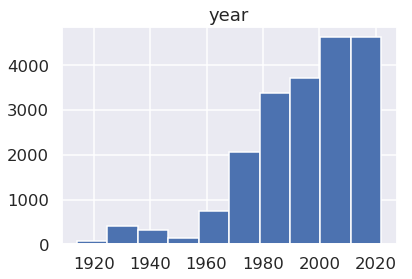

In [56]:
df.hist('year');

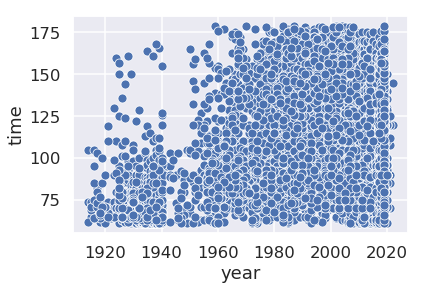

In [57]:
sns.scatterplot(df['year'], df['time']);

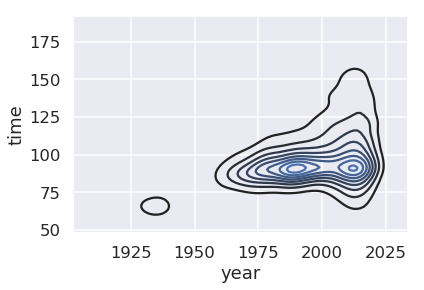

In [58]:
sns.kdeplot(df['year'], df['time']);

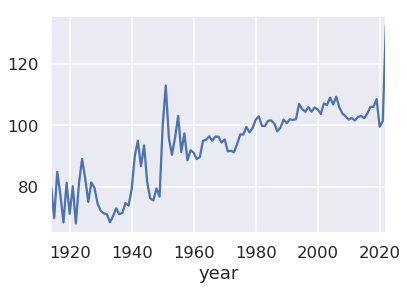

In [59]:
df['time'].groupby(df['year']).mean().plot();

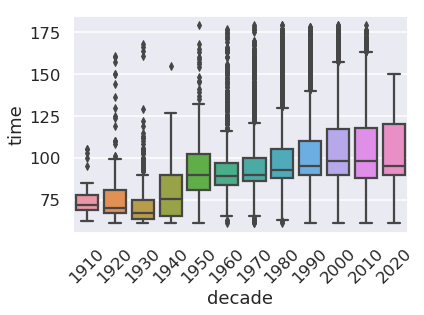

In [60]:
df['decade'] = (df['year'] // 10) * 10
sns.boxplot('decade', 'time', data=df)
plt.xticks(rotation=45);

## Sampling in SQL

In [61]:
pd.read_sql('SELECT * FROM action_movie ORDER BY RANDOM() LIMIT 3', conn)

,id,title,time,year
0,tt2193151,Mantera,117,2012
1,tt0198370,Chu cu chuo tou fa cu cai,82,1980
2,tt6170804,The Assassin's Code,95,2018


In [62]:
#selecting 3 random years
three_years = '''
SELECT year FROM action_movie 
  GROUP BY year 
  ORDER BY RANDOM()
  LIMIT 3
'''

pd.read_sql(three_years, conn)

,year
0,1935
1,1974
2,1994


In [63]:
#selecting all movies from 3 random years
three_years = '''
SELECT year FROM action_movie 
  GROUP BY year 
  ORDER BY RANDOM()
  LIMIT 3
'''

cluster_sample = f'''
SELECT * FROM action_movie 
WHERE year IN ({three_years})
'''

pd.read_sql(f'''
SELECT *
FROM ({cluster_sample}) 
''', conn)

,id,title,time,year
0,tt0010879,When the Clouds Roll by,85,1919
1,tt0080828,Encounter of the Spooky Kind II,87,1989
...,...,...,...,...
739,tt9486348,Cinema Enthusiast,95,2000
740,tt9697960,Nommara 17,107,1989


In [64]:
# Query has two select statements
# Inner select statement creates the table of 3 randomly chosen years.
print(cluster_sample)


SELECT * FROM action_movie 
WHERE year IN (
SELECT year FROM action_movie 
  GROUP BY year 
  ORDER BY RANDOM()
  LIMIT 3
)



## Ages of Fame

#### CASE Example

In [65]:
#case statement example
pd.read_sql('''
SELECT id, title, time, year,
     CASE WHEN time < 70 THEN 'short'
          WHEN time < 120 THEN 'medium'
          ELSE 'long'
     END as length
          
FROM action_movie
''', conn).sample(10)

,id,title,time,year,length
11389,tt0479660,Exodus: Tales from the Enchanted Kingdom,106,2005,medium
18209,tt5495248,Boxer,124,2015,long
...,...,...,...,...,...
6602,tt0221383,Mashamal - ritorno al deserto,98,1998,medium
5291,tt0165764,Ever Victorious Hall,76,1973,medium


In [66]:
#case statement example with a base expression
pd.read_sql('''
SELECT id, title, time, year,
     CASE year LIKE '%197%' WHEN True THEN '70s'          
          ELSE 'not 70s'
     END as decade
          
FROM action_movie
''', conn).sample(10)

,id,title,time,year,decade
7125,tt0251767,"Karakumy, 45 v teni",95,1982,not 70s
7689,tt0279848,El halcón solitario,75,1964,not 70s
...,...,...,...,...,...
1997,tt0090062,Stand Alone,94,1985,not 70s
7090,tt0249863,Pancho Villa and Valentina,87,1960,not 70s


#### SUBSTR Example

In [67]:
select_people = f'''
SELECT primaryName AS name, knownForTitles  
FROM names
'''

pd.read_sql(f'{select_people} LIMIT 10', conn)

,name,knownForTitles
0,Fred Astaire,"tt0050419,tt0043044,tt0053137,tt0072308"
1,Lauren Bacall,"tt0117057,tt0038355,tt0071877,tt0037382"
...,...,...
8,Richard Burton,"tt0087803,tt0061184,tt0057877,tt0059749"
9,James Cagney,"tt0042041,tt0035575,tt0031867,tt0029870"


In [68]:
select_people = f'''
SELECT primaryName AS name,   
  SUBSTR(knownForTitles, 0, INSTR(knownForTitles, ',')) AS most_popular_id
FROM names
'''

pd.read_sql(f'{select_people} LIMIT 10', conn)

,name,most_popular_id
0,Fred Astaire,tt0050419
1,Lauren Bacall,tt0117057
...,...,...
8,Richard Burton,tt0087803
9,James Cagney,tt0042041


### Age Trends

In [69]:
pd.read_sql('SELECT * FROM names LIMIT 10;', conn)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0050419,tt0043044,tt0053137,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0038355,tt0071877,tt0037382"
...,...,...,...,...,...,...
8,nm0000009,Richard Burton,1925,1984,"actor,producer,soundtrack","tt0087803,tt0061184,tt0057877,tt0059749"
9,nm0000010,James Cagney,1899,1986,"actor,soundtrack,director","tt0042041,tt0035575,tt0031867,tt0029870"


In [70]:
select_actors = f'''
SELECT primaryName AS name, 
  CAST(birthYear AS int) AS born,
  SUBSTR(knownForTitles, 0, INSTR(knownForTitles, ',')) AS movie_id,
  CASE WHEN primaryProfession LIKE '%actor%' THEN 'actor' 
    WHEN primaryProfession LIKE '%actress%' THEN 'actress'   
    END AS profession
FROM names
WHERE primaryProfession LIKE '%act%' AND
  born > 1800
'''

pd.read_sql(f'{select_actors} LIMIT 10', conn)

,name,born,movie_id,profession
0,Fred Astaire,1899,tt0050419,actor
1,Lauren Bacall,1924,tt0117057,actress
...,...,...,...,...
8,Richard Burton,1925,tt0087803,actor
9,James Cagney,1899,tt0042041,actor


In [71]:
select = f'''
SELECT name, profession, born, title, year
FROM ({select_actors}) JOIN action_movie
  ON movie_id = id;
'''

conn.executescript(f'''
DROP TABLE IF EXISTS action_ppl;
CREATE TABLE action_ppl AS {select};
''')

pd.read_sql('SELECT * FROM action_ppl LIMIT 10', conn)

,name,profession,born,title,year
0,John Belushi,actor,1949,1941,1979
1,Alec Guinness,actor,1914,Star Wars: Episode IV - A New Hope,1977
...,...,...,...,...,...
8,Antonio Banderas,actor,1960,Desperado,1995
9,Adrienne Barbeau,actress,1945,Escape from New York,1981


The table above gives us all the people whose first movie in IMDB's "known for" list is an action movie, along with the name of that movie. We call these people "action people".

There's a lot we can do with this table, i.e. we can find all the people whose top role has the word "Vampire" in it.

In [72]:
vampire_people = '''
SELECT *
FROM action_ppl
WHERE title LIKE "%Vampire%"
'''

pd.read_sql(vampire_people, conn)

,name,profession,born,title,year
0,Luke Perry,actor,1966,Buffy the Vampire Slayer,1992
1,Thomas Ian Griffith,actor,1962,Vampires,1998
...,...,...,...,...,...
52,Tim L. Brennon,actor,1961,Cirque du Freak: The Vampire's Assistant,2009
53,Iggy Azalea,actress,1990,Vampire Academy,2014


Or we can read in our dataframe into pandas and make a plot. Let's see the age of each actor when their best known movie was made.

In [73]:
df = pd.read_sql('SELECT * FROM action_ppl', conn)
df.shape

(17810, 5)

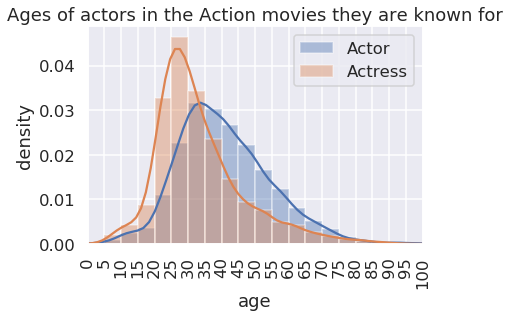

In [74]:
df['age'] = df['year'] - df['born']
bins = np.linspace(0, 100, 21)
sns.distplot(df[df['profession']=='actor']['age'], bins=bins)
sns.distplot(df[df['profession']=='actress']['age'], bins=bins)
plt.legend(labels=['Actor', 'Actress'])
plt.xticks(bins, rotation=90)
plt.xlim(0, 100)
plt.ylabel('density');
plt.title('Ages of actors in the Action movies they are known for');